In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,  accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import os

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\an_na\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\an_na\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
df = pd.read_csv('data/movie_metadata_final.csv')

In [3]:
df['imdbid'] = df['imdbid'].apply(lambda x: f'{x:07d}')

In [4]:
age_dummies = pd.get_dummies(df['age_rating_number'], prefix = 'age', drop_first=True, dtype=int)
df = pd.concat([df, age_dummies], axis=1)
df


,imdbid,title,year,age_rating,genre,description,director,runtime_minutes,production_budget,domestic_gross,...,genre_romance,genre_sci-fi,genre_sport,genre_thriller,genre_war,genre_western,age_6,age_13,age_17,age_18
0,0120770,A Night at the Roxbury,1998,PG-13,"Comedy, Music, Romance",Two dim-witted brothers dream of owning their ...,John Fortenberry,82.0,17000000.0,30331165.0,...,1,0,0,0,0,0,0,1,0,0
1,0132512,At First Sight,1999,PG-13,"Drama, Romance",A blind man has an operation to regain his sig...,Irwin Winkler,128.0,40000000.0,22365133.0,...,1,0,0,0,0,0,0,1,0,0
2,0118661,The Avengers,1998,PG-13,"Action, Adventure, Sci-Fi",Two British Agents team up to stop Sir August ...,Jeremiah S. Chechik,143.0,225000000.0,623357910.0,...,0,1,0,0,0,0,0,1,0,0
3,0118715,The Big Lebowski,1998,R,"Comedy, Crime","Ultimate L.A. slacker Jeff ""The Dude"" Lebowski...","Joel Coen, \nEthan Coen",117.0,15000000.0,17498804.0,...,0,0,0,0,0,0,0,0,1,0
4,0112573,Braveheart,1995,R,"Biography, Drama, History",Scottish warrior William Wallace leads his cou...,Mel Gibson,178.0,72000000.0,75545647.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,2209764,Transcendence,2014,PG-13,"Action, Drama, Sci-Fi",A scientist's drive for artificial intelligenc...,Wally Pfister,119.0,100000000.0,23022309.0,...,0,1,0,0,0,0,0,1,0,0
1234,0418279,Transformers,2007,PG-13,"Action, Adventure, Sci-Fi",An ancient struggle between two Cybertronian r...,Michael Bay,144.0,151000000.0,319246193.0,...,0,1,0,0,0,0,0,1,0,0
1235,6499752,Upgrade,2018,R,"Action, Sci-Fi, Thriller","Set in the near-future, technology controls ne...",Leigh Whannell,100.0,3000000.0,11977130.0,...,0,1,0,1,0,0,0,0,1,0
1236,1976009,Victor Frankenstein,2015,PG-13,"Drama, Horror, Sci-Fi","Told from Igor's perspective, we see the troub...",Paul McGuigan,110.0,40000000.0,5775076.0,...,0,1,0,0,0,0,0,1,0,0


In [5]:

df = df.drop([ 'title', 'year','age_rating', 'genre', 'description',
       'director', 'runtime_minutes','domestic_gross','age_rating_number',
       'worldwide_gross', 'ROI'], axis=1)


In [6]:
scaler = StandardScaler()
df['production_budget']= scaler.fit_transform(df[['production_budget']])
df

,imdbid,production_budget,financial_success,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_drama,...,genre_romance,genre_sci-fi,genre_sport,genre_thriller,genre_war,genre_western,age_6,age_13,age_17,age_18
0,0120770,-0.653835,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0132512,-0.183206,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0118661,3.602290,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0118715,-0.694760,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0112573,0.471582,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,2209764,1.044522,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1234,0418279,2.088091,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1235,6499752,-0.940305,1,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
1236,1976009,-0.183206,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


# Train Test Split and reading texts

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

## Lemmatized text

In [8]:
# Folder containing the text files
folder_path = 'data/movie_scripts/screenplay_data/data/raw_text_lemmas/raw_text_lemmas/'

# List to store the contents of the text files
lem_train_texts = []
counter = 0
ids_with_files = []
# Iterate through each ID in the DataFrame
for file_id in df_train['imdbid']:
    # Find the file that contains the ID
    for filename in os.listdir(folder_path):
        if file_id in filename:
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Open and read the file content
            with open(file_path, 'r', encoding="utf-8") as file:
                content = file.read()
                # Add the content to the list
                lem_train_texts.append(content)
                ids_with_files.append(file_id)
                counter += 1
                print(counter)
            break  # Break the loop once the file is found

df_train_corr = df_train[df_train['imdbid'].isin(ids_with_files)].reset_index(drop=True)
y_train = df_train_corr['financial_success']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [9]:
# Folder containing the text files
folder_path = 'data/movie_scripts/screenplay_data/data/raw_text_lemmas/raw_text_lemmas/'

# List to store the contents of the text files
lem_test_texts = []
counter = 0
ids_with_files = []
# Iterate through each ID in the DataFrame
for file_id in df_test['imdbid']:
    # Find the file that contains the ID
    for filename in os.listdir(folder_path):
        if file_id in filename:
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Open and read the file content
            with open(file_path, 'r', encoding="utf-8") as file:
                content = file.read()
                # Add the content to the list
                lem_test_texts.append(content)
                ids_with_files.append(file_id)
                counter += 1
                print(counter)
            break  # Break the loop once the file is found

df_test_corr = df_test[df_test['imdbid'].isin(ids_with_files)].reset_index(drop=True)
y_test = df_test_corr['financial_success']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


## Raw text

In [10]:
from charset_normalizer import from_path

# Folder containing the text files
folder_path = 'data/movie_scripts/screenplay_data/data/raw_texts/raw_texts/'

# List to store the contents of the text files
raw_train_texts = []
counter = 0
ids_with_files = []
# Iterate through each ID in the DataFrame
for file_id in df_train['imdbid']:
    # Find the file that contains the ID
    for filename in os.listdir(folder_path):
        if file_id in filename:
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Open and read the file content
            result = from_path(file_path).best()
            with open(file_path, 'r', encoding=result.encoding) as file:
                content = file.read()
                # Add the content to the list
                raw_train_texts.append(content)
                ids_with_files.append(file_id)
                counter += 1
                print(counter)
            break  # Break the loop once the file is found

df_train_corr = df_train[df_train['imdbid'].isin(ids_with_files)].reset_index(drop=True)
y_train = df_train_corr['financial_success']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [11]:
folder_path = 'data/movie_scripts/screenplay_data/data/raw_texts/raw_texts/'

# List to store the contents of the text files
raw_test_texts = []
counter = 0
ids_with_files = []
# Iterate through each ID in the DataFrame
for file_id in df_test['imdbid']:
    # Find the file that contains the ID
    for filename in os.listdir(folder_path):
        if file_id in filename:
            # Construct the full file path
            file_path = os.path.join(folder_path, filename)
            # Open and read the file content
            result = from_path(file_path).best()
            with open(file_path, 'r', encoding=result.encoding) as file:
                content = file.read()
                # Add the content to the list
                raw_test_texts.append(content)
                ids_with_files.append(file_id)
                counter += 1
                print(counter)
            break  # Break the loop once the file is found

df_test_corr = df_test[df_test['imdbid'].isin(ids_with_files)].reset_index(drop=True)
y_test = df_test_corr['financial_success']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


## Dropping imdbid and financial success

In [12]:
df_train_corr = df_train_corr.drop(['imdbid', 'financial_success'], axis=1)
df_test_corr = df_test_corr.drop(['imdbid', 'financial_success'], axis=1)
df_test_corr

,production_budget,genre_action,genre_adventure,genre_animation,genre_biography,genre_comedy,genre_crime,genre_drama,genre_family,genre_fantasy,...,genre_romance,genre_sci-fi,genre_sport,genre_thriller,genre_war,genre_western,age_6,age_13,age_17,age_18
0,0.430658,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0.839901,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-0.387828,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,-0.265055,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-0.899381,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,-0.183206,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
244,2.886115,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
245,3.233971,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
246,1.249144,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# TFIDF

In [13]:
df_lem_train = pd.DataFrame(lem_train_texts)
df_lem_test = pd.DataFrame(lem_test_texts)

In [14]:
# Step 3: TF-IDF Vectorization
vect= TfidfVectorizer(max_features=500, ngram_range=(1,3))
X_train_tfidf = vect.fit_transform(df_lem_train[0])
X_test_tfidf = vect.transform(df_lem_test[0])

Accuracy on train set: 1.0
Accuracy on test set: 0.67
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.50      0.26      0.34        82
           1       0.70      0.87      0.78       166

    accuracy                           0.67       248
   macro avg       0.60      0.56      0.56       248
weighted avg       0.64      0.67      0.63       248

--------------------------------------------------------------------------------


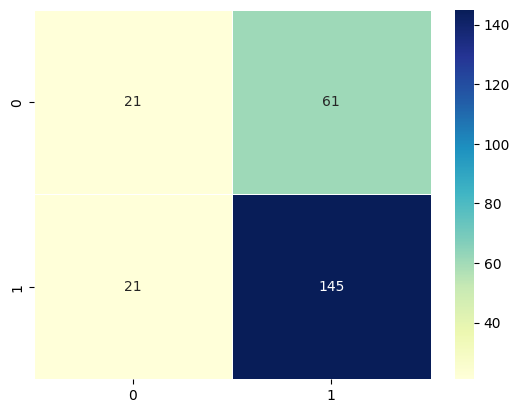

In [15]:
base = XGBClassifier()
base.fit(X_train_tfidf, y_train)

y_pred_train = base.predict(X_train_tfidf)
y_pred = base.predict(X_test_tfidf)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Latent Semantic Analysis (LSA)

In [16]:
from sklearn.decomposition import TruncatedSVD


lsa = TruncatedSVD(n_components=300, random_state=0)
X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)

Accuracy on train set: 1.0
Accuracy on test set: 0.64
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.40      0.20      0.26        82
           1       0.68      0.86      0.76       166

    accuracy                           0.64       248
   macro avg       0.54      0.53      0.51       248
weighted avg       0.59      0.64      0.60       248

--------------------------------------------------------------------------------


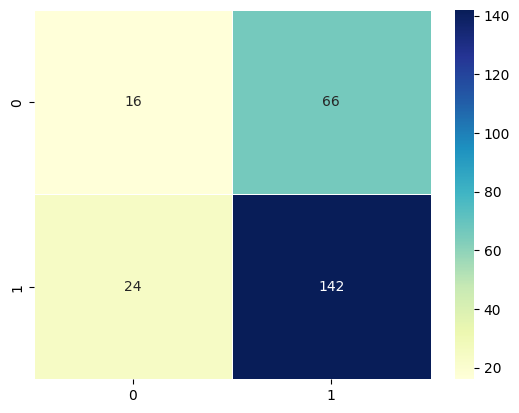

In [17]:
lsa_base = XGBClassifier()
lsa_base.fit(X_train_lsa, y_train)

y_pred_train = lsa_base.predict(X_train_lsa)
y_pred = lsa_base.predict(X_test_lsa)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Measure of Vocabulary Richness

In [18]:
#5 min

import nltk
from nltk.probability import FreqDist

# Function to calculate Measure of Vocabulary Richness (MVR)
def measure_of_vocabulary_richness(tokens, percentage):
    freq_dist = FreqDist(tokens)
    sorted_freq = sorted(freq_dist.values(), reverse=True)
    
    total_words = sum(sorted_freq)
    cumulative_sum = 0
    num_words = 0
    
    for freq in sorted_freq:
        cumulative_sum += freq
        num_words += 1
        if cumulative_sum >= total_words * percentage / 100:
            break
    
    return num_words / len(sorted_freq)

# Assuming 'df' is your dataframe with a column 'script_text' containing script texts
# Tokenize and calculate MVR for each script
def calculate_mvr(text, percentage):
    tokens = nltk.word_tokenize(text)
    return measure_of_vocabulary_richness(tokens, percentage)

# Calculate MVR for a certain percentage (e.g., 20%, 50%, 80%)
percentage = 20  # Adjust as needed
mvr_train = df_lem_train[0].apply(lambda x: calculate_mvr(x, percentage)).apply(pd.Series)
mvr_test = df_lem_test[0].apply(lambda x: calculate_mvr(x, percentage)).apply(pd.Series)


In [19]:
scaler = StandardScaler()
mvr_train = scaler.fit_transform(mvr_train)
mvr_test = scaler.transform(mvr_test)

# Textblob

In [20]:
df_raw_train = pd.DataFrame(raw_train_texts)
df_raw_test = pd.DataFrame(raw_test_texts)

df_raw_train[0] = df_raw_train[0].str.replace(r'\s+', ' ', regex=True).str.strip().str.lower()
df_raw_test[0] = df_raw_test[0].str.replace(r'\s+', ' ', regex=True).str.strip().str.lower()

In [21]:
#2 min
# from textblob import TextBlob

# def sentiment_analysis(text):
#     sentiment = TextBlob(text).sentiment
#     return sentiment.polarity

# df_train_corr['sentiment'] = df_raw_train[0].apply(sentiment_analysis)
# df_test_corr['sentiment'] = df_raw_test[0].apply(sentiment_analysis)

# X_train_meta = df_train_corr
# X_test_meta = df_test_corr



In [22]:
#2min 
from textblob import TextBlob

def sentiment_features(text):
    blob = TextBlob(text)
    return pd.Series({'polarity': blob.sentiment.polarity, 'subjectivity': blob.sentiment.subjectivity})

df_train_corr[['polarity', 'subjectivity']] = df_raw_train[0].apply(sentiment_features)
df_test_corr[['polarity', 'subjectivity']] = df_raw_test[0].apply(sentiment_features)

In [23]:
X_train_meta = df_train_corr
X_test_meta = df_test_corr

Accuracy on train set: 1.0
Accuracy on test set: 0.58
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.32      0.26      0.29        82
           1       0.67      0.73      0.70       166

    accuracy                           0.58       248
   macro avg       0.49      0.50      0.49       248
weighted avg       0.55      0.58      0.56       248

--------------------------------------------------------------------------------


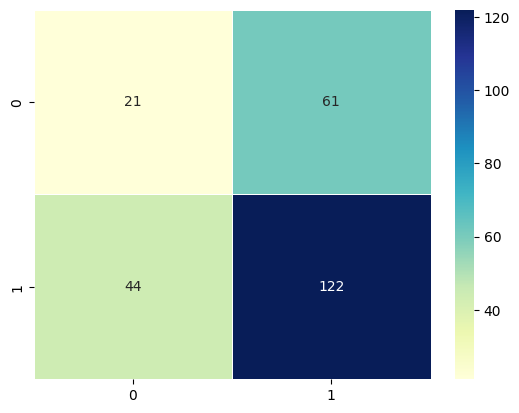

In [24]:
meta_base = XGBClassifier()
meta_base.fit(X_train_meta, y_train)

y_pred_train = meta_base.predict(X_train_meta)
y_pred = meta_base.predict(X_test_meta)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


              precision    recall  f1-score   support

           0       0.38      0.06      0.11        82
           1       0.67      0.95      0.79       166

    accuracy                           0.66       248
   macro avg       0.53      0.51      0.45       248
weighted avg       0.58      0.66      0.56       248

ROC_score:  0.50639141933588


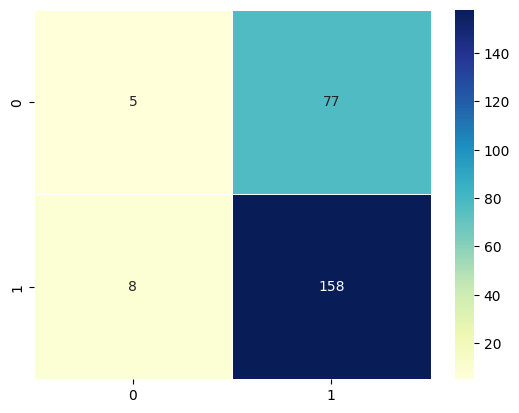

In [25]:
# Define parameter grid for randomized search
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1,  2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5,  9],
        'learning_rate' : [0.1, 0.3, 1.0],
        'lambda' : [0.3, 1, 5]
        }


# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(XGBClassifier(), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=0)

# Fit randomized search object to data
rs.fit(X_train_meta, y_train)

rs_best = rs.best_estimator_
y_pred = rs_best.predict(X_test_meta)
print(classification_report(y_test,y_pred))
print('ROC_score: ', roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# LDA

In [26]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [27]:
#9 min

# Apply CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_train_counts = vectorizer.fit_transform(df_raw_train[0])
X_test_counts = vectorizer.transform(df_raw_test[0])

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=0)
X_train_topics = lda.fit_transform(X_train_counts)
X_test_topics = lda.transform(X_test_counts)

# Add LDA topic distribution to the DataFrame
lda_columns = [f'topic_{i}' for i in range(X_train_topics.shape[1])]
df_train_lda = pd.DataFrame(X_train_topics, columns=lda_columns)
df_test_lda = pd.DataFrame(X_test_topics, columns=lda_columns)
# df = pd.concat([df, df_lda], axis=1)

In [28]:
y_train

0      0
1      0
2      0
3      1
4      0
      ..
985    1
986    1
987    0
988    1
989    1
Name: financial_success, Length: 990, dtype: int64

Accuracy on train set: 1.0
Accuracy on test set: 0.6
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.29      0.13      0.18        82
           1       0.66      0.84      0.74       166

    accuracy                           0.60       248
   macro avg       0.48      0.49      0.46       248
weighted avg       0.54      0.60      0.56       248

--------------------------------------------------------------------------------


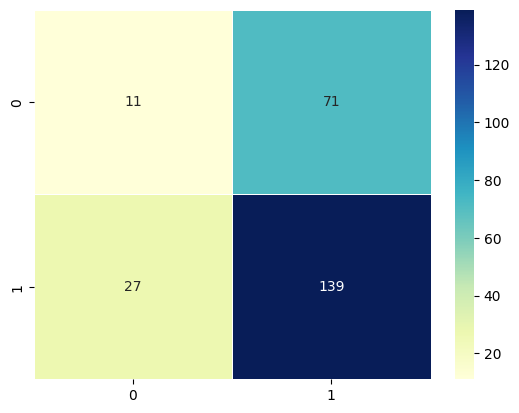

In [29]:
lda_base = XGBClassifier()
lda_base.fit(df_train_lda, y_train)

y_pred_train = lda_base.predict(df_train_lda)
y_pred = lda_base.predict(df_test_lda)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Readability score

In [30]:
#1 min
import textstat

def readability_features(text):
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
    return {'flesch_reading_ease': flesch_reading_ease, 'flesch_kincaid_grade': flesch_kincaid_grade}

# flesch_train_reading_ease = df_raw_train[0].apply(textstat.flesch_reading_ease)
# flesch_train_kincaid_grade = df_raw_train[0].apply(textstat.flesch_kincaid_grade)
df_train_read = df_raw_train[0].apply(readability_features).apply(pd.Series)
df_test_read = df_raw_test[0].apply(readability_features).apply(pd.Series)



Accuracy on train set: 0.7
Accuracy on test set: 0.62
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.31      0.11      0.16        82
           1       0.67      0.88      0.76       166

    accuracy                           0.62       248
   macro avg       0.49      0.49      0.46       248
weighted avg       0.55      0.62      0.56       248

--------------------------------------------------------------------------------


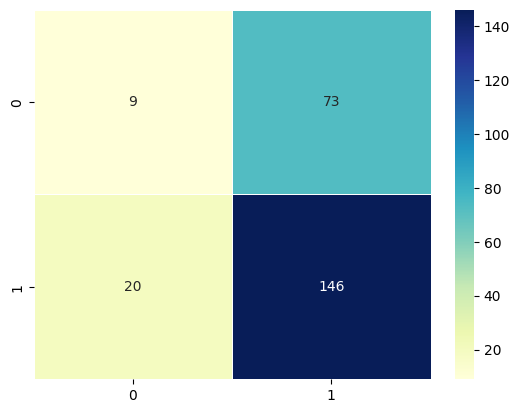

In [31]:
read_base = XGBClassifier()
read_base.fit(df_train_read, y_train)

y_pred_train = read_base.predict(df_train_read)
y_pred = read_base.predict(df_test_read)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# Glove

In [32]:
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings('data/glove.6B/glove.6B.300d.txt')
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [33]:
def get_script_embedding(script, embeddings_index, embedding_dim=300):
    words = script.split()
    valid_embeddings = [embeddings_index[word] for word in words if word in embeddings_index]
    if not valid_embeddings:
        return np.zeros(embedding_dim)
    return np.mean(valid_embeddings, axis=0)

# df_train_corr['script_embedding'] = df_raw_train[0].apply(lambda x: get_script_embedding(x, embeddings_index))
# X_train_text = np.vstack(df_train_corr['script_embedding'].values)
X_train_text = np.vstack(df_raw_train[0].apply(lambda x: get_script_embedding(x, embeddings_index)).values)

# df_test_corr['script_embedding'] = df_raw_test[0].apply(lambda x: get_script_embedding(x, embeddings_index))
# X_test_text = np.vstack(df_test_corr['script_embedding'].values)
X_test_text = np.vstack(df_raw_test[0].apply(lambda x: get_script_embedding(x, embeddings_index)).values)

Accuracy on train set: 1.0
Accuracy on test set: 0.63
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.39      0.20      0.26        82
           1       0.68      0.85      0.76       166

    accuracy                           0.63       248
   macro avg       0.54      0.52      0.51       248
weighted avg       0.58      0.63      0.59       248

--------------------------------------------------------------------------------


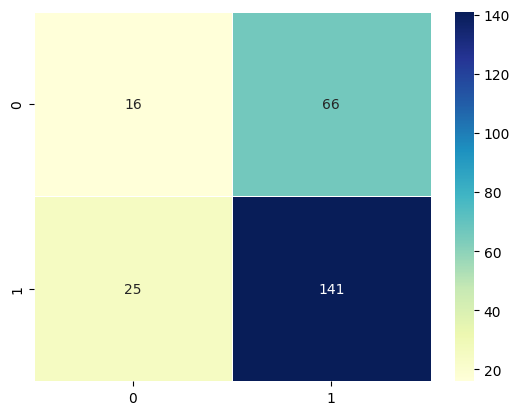

In [34]:
clf = XGBClassifier()
clf.fit(X_train_text, y_train)

y_pred_train = clf.predict(X_train_text)
y_pred = clf.predict(X_test_text)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.33      0.22      0.26        82
           1       0.67      0.78      0.72       166

    accuracy                           0.60       248
   macro avg       0.50      0.50      0.49       248
weighted avg       0.56      0.60      0.57       248

ROC_score:  0.5013223626212165


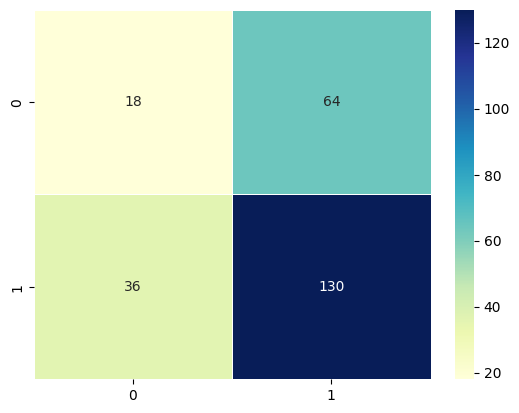

In [35]:
# Define parameter grid for randomized search
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1,  2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5,  9],
        'learning_rate' : [0.1, 0.3, 1.0],
        'lambda' : [0.3, 1, 5]
        }


# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(XGBClassifier(), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=0)

# Fit randomized search object to data
rs.fit(X_train_text, y_train)

rs_best = rs.best_estimator_
y_pred = rs_best.predict(X_test_text)
print(classification_report(y_test,y_pred))
print('ROC_score: ', roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

# combination test

In [36]:
from scipy.sparse import hstack

X_train_combined = hstack([X_train_text, X_train_meta,  X_train_tfidf, df_train_lda, df_train_read, mvr_train, X_train_lsa])
X_test_combined = hstack([X_test_text, X_test_meta,  X_test_tfidf, df_test_lda, df_test_read, mvr_test, X_test_lsa])

Accuracy on train set: 1.0
Accuracy on test set: 0.63
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.34      0.13      0.19        82
           1       0.67      0.87      0.76       166

    accuracy                           0.63       248
   macro avg       0.51      0.50      0.48       248
weighted avg       0.56      0.63      0.57       248

ROC_score:  0.5038201586835146


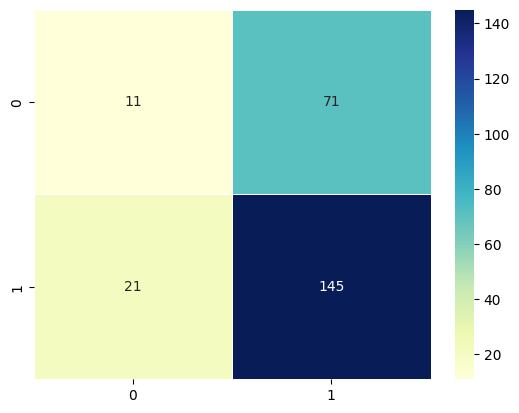

In [37]:

clf = XGBClassifier()
clf.fit(X_train_combined, y_train)

y_pred_train = clf.predict(X_train_combined)
y_pred = clf.predict(X_test_combined)

# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))

print('ROC_score: ', roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
              precision    recall  f1-score   support

           0       0.34      0.18      0.24        82
           1       0.67      0.83      0.74       166

    accuracy                           0.61       248
   macro avg       0.51      0.50      0.49       248
weighted avg       0.56      0.61      0.57       248

ROC_score:  0.5041140170437849


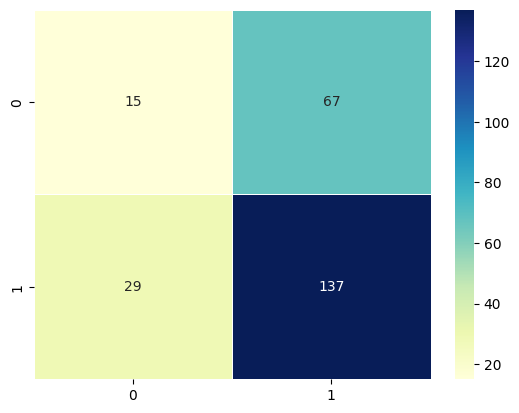

In [38]:
# Define parameter grid for randomized search
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1,  2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5,  9],
        'learning_rate' : [0.1, 0.3, 1.0],
        'lambda' : [0.3, 1, 5]
        }


# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(XGBClassifier(), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=0)

# Fit randomized search object to data
rs.fit(X_train_combined, y_train)

rs_best = rs.best_estimator_
y_pred = rs_best.predict(X_test_combined)
print(classification_report(y_test,y_pred))
print('ROC_score: ', roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

In [39]:
'''
# Define parameter grid for randomized search
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1,  2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5,  9],
        'learning_rate' : [0.1, 0.3, 1.0],
        'lambda' : [0.3, 1, 5]
        }


# Instantiate random search and define the metric to optimize 
gs = GridSearchCV(XGBClassifier(), param_grid,  scoring='accuracy',
                  cv=5, verbose=3, n_jobs=-1)

# Fit randomized search object to data
gs.fit(X_train, y_train)

gs_best = gs.best_estimator_
y_pred = gs_best.predict(X_test)
print(classification_report(y_test,y_pred))
print('ROC_score: ', roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);
'''

"\n# Define parameter grid for randomized search\nparam_grid = {\n        'min_child_weight': [1, 5, 10],\n        'gamma': [0, 0.5, 1,  2, 5],\n        'subsample': [0.6, 0.8, 1.0],\n        'colsample_bytree': [0.6, 0.8, 1.0],\n        'max_depth': [3, 5,  9],\n        'learning_rate' : [0.1, 0.3, 1.0],\n        'lambda' : [0.3, 1, 5]\n        }\n\n\n# Instantiate random search and define the metric to optimize \ngs = GridSearchCV(XGBClassifier(), param_grid,  scoring='accuracy',\n                  cv=5, verbose=3, n_jobs=-1)\n\n# Fit randomized search object to data\ngs.fit(X_train, y_train)\n\ngs_best = gs.best_estimator_\ny_pred = gs_best.predict(X_test)\nprint(classification_report(y_test,y_pred))\nprint('ROC_score: ', roc_auc_score(y_test, y_pred))\ncm = confusion_matrix(y_test, y_pred)\nsns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);\n"